## VarQITE
Variational Quantum Imaginary Time Evolution can be executed through the gradient framework's `NaturalGradient`.

#### Setting the stage

First define the evolution time and operator (Hamiltonina) as well as the Ansatz.

In [26]:
import numpy as np

from qiskit.aqua.operators import SummedOp, StateFn, Z, I, ListOp
from qiskit.aqua.operators.gradients import NaturalGradient
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZGate, YGate

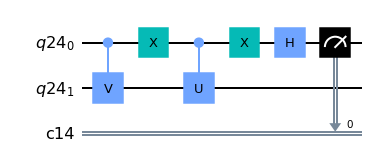

In [29]:
qr = QuantumRegister(2)
qr_v = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
v = YGate(label='V')
u = YGate(label='U')
cv = v.control(1)
cu = u.control(1)
qc.append(cv, qr)
qc.x(qr[0])
qc.append(cu, qr)
qc.x(qr[0])
qc.h(qr[0])
qc.measure(qr[0], cr[0])
qc.draw(output='mpl')

In [7]:
EfficientSU2(num_qubits=3, reps=1, parameter_prefix=r'$\omega$').draw(output='mpl', filename='efficientSU2.pdf')

WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


CalledProcessError: Command '['pdflatex', '-halt-on-error', '-output-directory=/var/folders/l2/21_vxlh11kscx1fq9x7xzlfm0000kp/T/tmpfz5ui7ea', 'circuit.tex']' returned non-zero exit status 1.

In [2]:
# Evolution time
t =  1
num_qubits = 4
# Instantiate the model ansatz
depth = 1
entangler_map = [[i+1, i] for i in range(num_qubits - 1)]
ansatz = EfficientSU2(num_qubits, reps=depth, entanglement = entangler_map)

In [3]:
# Define the model Hamiltonian
H = SummedOp([0.3 * Z^Z^ I^I, 0.2 * Z^I^ I^I, - 0.5 * I ^ Z^ I^I])


# Define the expectation value given the Hamiltonian as observable and the state generated by the Ansatz    
op = ~StateFn(H) @ StateFn(ansatz)

Change lines 87-88 in natural_gradient.py to

```python
if not isinstance(operator, CircuitStateFn) ^ (not isinstance(operator, ComposedOp) \
                  or not isinstance(operator[-1], CircuitStateFn)):
```

If you want to use a more generic loss function. Then uncommen the next 

In [4]:
# def combo_fn(x):
#     # log-likelihood
#     amplitudes = x[0].primitive.data
#     pdf = np.multiply(amplitudes, np.conj(amplitudes))
#     return np.sum(np.log(pdf))/(-len(amplitudes))

# def grad_combo_fn(x):
#     amplitudes = x[0].primitive.data
#     pdf = np.multiply(amplitudes, np.conj(amplitudes))
#     grad = []
#     for p in pdf:
#         grad += [-1/p]
#     return grad

# # qc = RealAmplitudes(2, reps=2)
# # lambda x: jnp.sum(jnp.log(x))/(-len(x))
# op = ListOp([StateFn(ansatz)], combo_fn=combo_fn, grad_combo_fn=grad_combo_fn)
# # grad = Gradient().convert(grad_op, qc.ordered_parameters)

#### Execute VarQITE
Next, choose discretization of the time evolution, i.e., the number of time steps.

In [5]:
# Set the discretization grid of the time steps
num_time_steps = 20
time_steps = np.linspace(0, t, num_time_steps)

# Convert the operator that holds the Hamiltonian and Ansatz using the NaturalGradient 
nat_grad = NaturalGradient(grad_method = 'lin_comb', regularization = 'ridge').convert(op, ansatz.ordered_parameters)

# Initialize the Ansatz parameters
param_values = np.random.rand(len(ansatz.ordered_parameters))

# Propagate the Ansatz parameters step by step (here with explicit Euler)
for step in time_steps:
    param_dict = dict(zip(ansatz.ordered_parameters, param_values))
    nat_grad_result = np.real(nat_grad.assign_parameters(param_dict).eval())
    param_values = list(np.subtract(param_values, t/num_time_steps * np.real(nat_grad_result.flatten())))
    print('Loss',
          op.assign_parameters(dict(zip(ansatz.ordered_parameters, param_values))).eval())

Loss (3.9426030378122205-0j)
Loss (3.043366144360328-0j)
Loss (3.6861754107528037-0j)
Loss (3.3402497655689762-0j)
Loss (3.3128022079473243-0j)
Loss (3.0120804948487394-0j)
Loss (3.8854464044941306-0j)
Loss (3.3724899035385865-0j)
Loss (3.8483789739355667-0j)
Loss (5.367714756893302-0j)
Loss (3.875719133847667-0j)
Loss (3.2373570799523286-0j)
Loss (3.2161337576672033-0j)
Loss (3.5360016462746815-0j)
Loss (3.681414230745951-0j)
Loss (3.161726700698442-0j)
Loss (4.695546837020616-0j)
Loss (3.352288191218965-0j)
Loss (3.333934945366777-0j)
Loss (2.8793586795989152-0j)


#### Training result
Now, we can print the final parameters and use them to prepare an approximation to the evolved quantum state.

In [6]:
print('Final values', param_values)

Final values [67.38788241948362, -31.554818105679477, 0.9157960169834258, -14.715883212769462, 38.45392001081735, 22.142258055461756, -27.070529012925277, 3.292512489418368, -56.38939969196619, -64.44528424571533, 12.360114060738164, 10.898626772101657, 14.260054440691725, 6.424948513259233, -10.70431126890085, -5.042022567739451]
